In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Choose a range of date for which we want to generate the feature matrix 
# The earliest start date allowed is 2021-01-01
start_date = '2021-08-01T00:00:00.000'
end_date = '2021-11-28T00:00:00.000'

# Read in the dynamic and static data files
df_state_static = pd.read_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/static_state_features.csv')
df_county_static = pd.read_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/counties_static_features.csv')
df_covid_cases = pd.read_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/CDC_COVID19_cases_and_vaccine_time_series/covid_cases_by_county.csv')
df_covid_vaccine = pd.read_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/CDC_COVID19_cases_and_vaccine_time_series/vaccine_status_by_county.csv')

# Delete the unnecessary indexing column
df_state_static = df_state_static.drop(df_state_static.columns[0], axis=1)
df_county_static = df_county_static.drop(df_county_static.columns[0], axis=1)
df_covid_cases = df_covid_cases.drop(df_covid_cases.columns[0], axis = 1)

### Preprocessing the static data

In [4]:
# For county data, we don't need the column that indicates the state
df_county_static = df_county_static.drop('State', 1)

# Combine the state and county static features together into a single matrix
# The first 51 rows are state-wise features, the rest of the 3142 rows are county-wise features
# Both state and county have the same kind of features
df_state_static = df_state_static.rename({'State': 'location'}, axis='columns') 
df_county_static = df_county_static.rename({'County': 'location'}, axis='columns')
df_state_and_county_static = pd.concat([df_state_static, df_county_static])
df_state_and_county_static = df_state_and_county_static.reset_index(drop = True)
df_state_and_county_static['location'] = df_state_and_county_static['location'].str.lower()
# Create a location name -- FIPS mapper in a dictionary
location_fips_mapping = dict(zip(df_state_and_county_static['location'][0:51], df_state_and_county_static['FIPS'][0:51]))


### Preprocessing the dynamic data

In [5]:
# For COVID cases data, drop any rows that have missing values for cases_per_100k_7_day_count or percent_test_results_reported
df_covid_cases['cases_per_100k_7_day_count'] = df_covid_cases['cases_per_100k_7_day_count'].replace('suppressed', np.nan)

# Count number of missing data for each COVID variable
print('Number of missing for cases per 100k ', df_covid_cases['cases_per_100k_7_day_count'].isnull().sum())
print('Number of missing for percent_test ', df_covid_cases['percent_test_results_reported'].isnull().sum())

df_covid_cases_no_missing = df_covid_cases.dropna(subset = ['cases_per_100k_7_day_count'])
df_covid_cases_no_missing = df_covid_cases_no_missing.reset_index(drop = True)

# Clean the numbers by getting rid of the comma in the numbers
df_covid_cases_no_missing['cases_per_100k_7_day_count'] = df_covid_cases_no_missing.apply(lambda x: x['cases_per_100k_7_day_count'].replace(',', ''),axis=1)
df_covid_cases_no_missing['cases_per_100k_7_day_count'] = pd.to_numeric(df_covid_cases_no_missing['cases_per_100k_7_day_count'])
#df_covid_cases_no_missing['percent_test_results_reported'] = pd.to_numeric(df_covid_cases_no_missing['percent_test_results_reported'])

# For vaccine data, drop any rows that have missing values for series_complete_pop_pct 
df_covid_vaccine_no_missing = df_covid_vaccine.dropna(subset = ['series_complete_yes'])
df_covid_vaccine_no_missing = df_covid_vaccine_no_missing.reset_index(drop = True)

print('Number of rows with missing values for COVID cases info from March 1 2020 to Nov 2021', len(df_covid_cases) - len(df_covid_cases_no_missing))
print('Number of rows with missing values for COVID vaccine info from March 1 2020 to Nov 2021', len(df_covid_vaccine) - len(df_covid_vaccine_no_missing))

Number of missing for cases per 100k  471771
Number of missing for percent_test  170123
Number of rows with missing values for COVID cases info from March 1 2020 to Nov 2021 471771
Number of rows with missing values for COVID vaccine info from March 1 2020 to Nov 2021 0


In [6]:
# Reference: https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "Washington DC": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# Swap the key and value because we want to convert abbreviation to full name
us_abbrev_to_state = dict((v,k) for k,v in us_state_to_abbrev.items())


In [7]:
# From the entire COVID dynamic data, take out the data within a desired date range
# Here sorting does not affect results. It was used for debugging purpose.
def select_data_by_dates(df_input):
  df_sorted = df_input.sort_values(['date', 'state_name'])
  df_sorted['date'] = pd.to_datetime(df_sorted['date'])

  # Incorporate additional past 7 days from the starting day because we need to generate the historical 7-day COVID information later on.
  df_sorted = df_sorted[df_sorted['date'] >= pd.to_datetime(start_date) - timedelta(days = 7)]
  df_sorted = df_sorted[df_sorted['date'] <= pd.to_datetime(end_date)]

  df_sorted = df_sorted.reset_index(drop = True)
  df = df_sorted
  return df

# Rename some columns for vaccine data to be the same as the ones in the covid cases data so that later we can merge vaccine and cases data together
df_covid_vaccine_no_missing = df_covid_vaccine_no_missing.rename(columns= {'date': 'date', 
                                                                           'fips': 'fips_code', 'recip_county': 'county_name', 
                                                                           'recip_state': 'state_name'})

df_cases_selected_by_dates = select_data_by_dates(df_covid_cases_no_missing)
df_vaccine_selected_by_dates = select_data_by_dates(df_covid_vaccine_no_missing)

# Modify the location names of the covid cases dynamic data so that it is consistent with the static data
# Convert the state abbrev to full name for vaccine data
df_vaccine_selected_by_dates['state_name'] = df_vaccine_selected_by_dates['state_name'].map(us_abbrev_to_state)
df_vaccine_selected_by_dates['state_name'] = df_vaccine_selected_by_dates['state_name'].str.lower()
df_vaccine_selected_by_dates['county_name'] = df_vaccine_selected_by_dates['county_name'].str.lower()
# Somehow there are rows with FIPS code be "UNK". Need to drop these rows.
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['fips_code'] != 'UNK']
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates.reset_index(drop = True)
df_vaccine_selected_by_dates['fips_code'] = pd.to_numeric(df_vaccine_selected_by_dates['fips_code'])

df_cases_selected_by_dates['state_name'] = df_cases_selected_by_dates['state_name'].str.lower()
df_cases_selected_by_dates['county_name'] = df_cases_selected_by_dates['county_name'].str.lower()
df_cases_selected_by_dates['state_name'] = df_cases_selected_by_dates['state_name'].replace('district of columbia', 'washington dc')
df_cases_selected_by_dates['county_name'] = df_cases_selected_by_dates['county_name'].replace('district of columbia', 'washington dc')
df_cases_selected_by_dates['county_name'] = df_cases_selected_by_dates['county_name'].replace('lasalle parish', 'la salle parish')
df_cases_selected_by_dates['county_name'] = df_cases_selected_by_dates['county_name'].replace('doña ana county', 'dona ana county')

# Get rid of locations that don't exist in the static data 
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['state_name'] != 'american samoa'] 
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['state_name'] != 'northern mariana islands'] 
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['state_name'] != 'guam'] 
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['state_name'] != 'puerto rico'] 
df_vaccine_selected_by_dates = df_vaccine_selected_by_dates[df_vaccine_selected_by_dates['state_name'] != 'u.s. virgin islands'] 


df_cases_selected_by_dates = df_cases_selected_by_dates[df_cases_selected_by_dates['state_name'] != 'puerto rico'] 
df_cases_selected_by_dates = df_cases_selected_by_dates.reset_index(drop = True)

# Store the dates in a list so that later we can loop through each date and create relevant data for each date.
dates_list = df_cases_selected_by_dates['date'].drop_duplicates()
dates_list = dates_list.reset_index(drop = True)


### Create a dataframe with date (both user-specified and historical), location name, FIPS, and COVID variable as columns 

The feature matrix will be made based on this dataframe later.

In [8]:
def create_cleaned_df_for_dynamic_features(dates_list, df_input, variable_name):
  print('For variable ', variable_name)
  results_across_days = []
  for date_index in range(len(dates_list)):
    # Process each day separately 
    date = dates_list[date_index]
    groups_by_date = df_input.groupby('date')
    print('Processing ', date)

    # Find the rows/locations corresponding to the same date
    df_data_with_same_date = groups_by_date.get_group(date)
    df_data_with_same_date = df_data_with_same_date.reset_index(drop = True)

    # Calculate state-level COVID numbers by aggregating across the counties in that state
    # Within the rows with the same date, find the ones with the same US state name
    groups_by_state_indices = df_data_with_same_date.groupby('state_name').indices
    for key, value in groups_by_state_indices.items():
      state_name = key
      # For each state, get its COVID data by summing over all its counties 
      FIPS_of_location = location_fips_mapping[state_name]
      state_level_result = sum(df_data_with_same_date[variable_name][value])
      results_across_days.append((date, state_name, FIPS_of_location, state_level_result))

    # After getting the state-level data, we simply save the county level COVID data 
    for county_index in range(len(df_data_with_same_date)): 
      county_name = df_data_with_same_date['county_name'][county_index]
      county_FIPS = df_data_with_same_date['fips_code'][county_index]
      county_level_result = df_data_with_same_date[variable_name][county_index]
      results_across_days.append((date, county_name, county_FIPS, county_level_result))

  # Save as a dataframe
  df_results = pd.DataFrame(results_across_days, columns = ['date', 'location', 'FIPS', variable_name])
  # Convert the date type into datetime so that the dates can be calculated later
  df_results['date'] = pd.to_datetime(df_results['date'])
  print('Number of resulting rows ', len(df_results))
  return df_results

df_cleaned_covid_cases = create_cleaned_df_for_dynamic_features(dates_list, df_cases_selected_by_dates, 'cases_per_100k_7_day_count')
df_cleaned_covid_vaccine = create_cleaned_df_for_dynamic_features(dates_list, df_vaccine_selected_by_dates, 'series_complete_yes')


For variable  cases_per_100k_7_day_count
Processing  2021-07-25 00:00:00
Processing  2021-07-26 00:00:00
Processing  2021-07-27 00:00:00
Processing  2021-07-28 00:00:00
Processing  2021-07-29 00:00:00
Processing  2021-07-30 00:00:00
Processing  2021-07-31 00:00:00
Processing  2021-08-01 00:00:00
Processing  2021-08-02 00:00:00
Processing  2021-08-03 00:00:00
Processing  2021-08-04 00:00:00
Processing  2021-08-05 00:00:00
Processing  2021-08-06 00:00:00
Processing  2021-08-07 00:00:00
Processing  2021-08-08 00:00:00
Processing  2021-08-09 00:00:00
Processing  2021-08-10 00:00:00
Processing  2021-08-11 00:00:00
Processing  2021-08-12 00:00:00
Processing  2021-08-13 00:00:00
Processing  2021-08-14 00:00:00
Processing  2021-08-15 00:00:00
Processing  2021-08-16 00:00:00
Processing  2021-08-17 00:00:00
Processing  2021-08-18 00:00:00
Processing  2021-08-19 00:00:00
Processing  2021-08-20 00:00:00
Processing  2021-08-21 00:00:00
Processing  2021-08-22 00:00:00
Processing  2021-08-23 00:00:00

### Merging the data across days 

The purpose is to find the locations that have complete data on every single day within the given date range.

In [9]:

variable_name = 'cases_per_100k_7_day_count'
grouped_results = df_cleaned_covid_cases.groupby('date')
df_merged_temporal_current = grouped_results.get_group(dates_list[0])
for date_index in range(1, len(dates_list)):
  df_nth_day = grouped_results.get_group(dates_list[date_index])
  # Some preprocessing on column names to make the merging easier
  df_nth_day = df_nth_day.drop('date', 1)
  df_nth_day = df_nth_day.reset_index(drop = True)
  df_nth_day = df_nth_day.rename(columns = {variable_name: str(dates_list[date_index])[0:10]})

  # Merging 
  df_merged_temporal = pd.merge(df_nth_day, df_merged_temporal_current, on = 'FIPS')
  df_merged_temporal = df_merged_temporal.drop('location_y', 1)
  df_merged_temporal = df_merged_temporal.rename(columns = {'location_x': 'location'})
  df_merged_temporal_current = df_merged_temporal
  
df_merged_temporal_current = df_merged_temporal_current.drop('date', 1)
df_merged_temporal_current = df_merged_temporal_current.rename(columns = {'cases_per_100k_7_day_count' : str(dates_list[0])[0:10]})
df_merged_temporal_current = df_merged_temporal_current.sort_values(by = 'FIPS')
df_merged_temporal_current = df_merged_temporal_current.reset_index(drop = True)

In [10]:
df_merged_temporal_current

,location,FIPS,2021-11-28,2021-11-27,2021-11-26,2021-11-25,2021-11-24,2021-11-23,2021-11-22,2021-11-21,2021-11-20,2021-11-19,2021-11-18,2021-11-17,2021-11-16,2021-11-15,2021-11-14,2021-11-13,2021-11-12,2021-11-11,2021-11-10,2021-11-09,2021-11-08,2021-11-07,2021-11-06,2021-11-05,2021-11-04,2021-11-03,2021-11-02,2021-11-01,2021-10-31,2021-10-30,2021-10-29,2021-10-28,2021-10-27,2021-10-26,2021-10-25,2021-10-24,2021-10-23,2021-10-22,...,2021-09-02,2021-09-01,2021-08-31,2021-08-30,2021-08-29,2021-08-28,2021-08-27,2021-08-26,2021-08-25,2021-08-24,2021-08-23,2021-08-22,2021-08-21,2021-08-20,2021-08-19,2021-08-18,2021-08-17,2021-08-16,2021-08-15,2021-08-14,2021-08-13,2021-08-12,2021-08-11,2021-08-10,2021-08-09,2021-08-08,2021-08-07,2021-08-06,2021-08-05,2021-08-04,2021-08-03,2021-08-02,2021-08-01,2021-07-31,2021-07-30,2021-07-29,2021-07-28,2021-07-27,2021-07-26,2021-07-25
0,alabama,1000,3364.449,3551.950,4545.836,5578.760,5800.495,6068.113,5904.042,5810.764,5691.403,5585.449,5502.085,5702.021,5391.201,6480.039,6431.687,6512.785,6281.696,6287.392,6937.271,7263.681,6669.982,6641.263,6868.655,6613.376,6405.174,8468.815,18329.066,18912.761,19103.835,19272.180,19880.084,21125.573,19297.906,9388.298,8596.595,8570.970,8960.861,9009.750,...,44121.554,51309.357,44959.914,37365.080,36641.188,36395.237,36749.034,34824.985,26527.831,32377.362,37960.992,37602.113,41624.232,33312.030,33092.276,32593.826,31777.162,31068.484,33854.353,25635.734,30490.688,29817.584,29351.051,28354.876,27441.480,23731.199,25683.194,30782.479,26409.862,21753.581,20900.186,20100.018,19862.920,19434.222,11833.005,14108.852,16158.599,14827.399,13275.020,12244.063
1,autauga county,1001,82.335,87.705,98.445,130.663,152.142,136.032,125.293,121.713,119.923,132.453,118.133,121.713,123.503,128.873,128.873,132.453,123.503,123.503,127.083,141.402,137.822,141.402,157.511,153.932,152.142,359.770,375.879,375.879,366.930,350.821,467.164,474.324,309.653,272.065,257.746,261.326,268.485,150.352,...,692.692,834.094,762.498,692.692,619.306,628.255,628.255,579.928,357.980,431.366,485.063,511.912,635.415,479.694,486.853,497.593,488.643,488.643,501.172,332.922,424.207,393.778,391.988,363.350,363.350,325.762,372.299,384.829,341.871,279.225,284.594,268.485,257.746,241.637,152.142,162.881,186.150,162.881,152.142,128.873
2,baldwin county,1003,39.421,38.973,45.692,54.203,57.339,55.099,55.995,54.203,56.443,62.714,69.434,75.705,68.986,96.759,97.207,99.447,129.909,129.909,127.221,130.804,104.823,104.823,105.271,70.330,64.954,60.923,71.674,71.226,69.882,68.538,66.298,70.778,70.778,70.778,75.257,76.601,78.841,80.633,...,717.633,876.659,796.026,658.502,669.701,704.194,703.298,793.786,661.638,827.831,931.310,932.654,1034.789,830.967,783.035,813.496,774.524,787.066,894.129,685.827,809.465,844.853,826.487,840.374,855.604,761.085,847.093,1040.612,883.826,750.782,737.791,736.895,711.809,689.411,453.336,528.593,589.068,529.041,468.567,451.544
3,butler county,1013,61.703,77.129,123.406,149.116,164.541,190.251,179.967,164.541,164.541,113.122,87.413,82.271,61.703,66.845,61.703,51.419,51.419,66.845,66.845,82.271,128.548,138.832,143.974,159.399,149.116,174.825,411.353,442.205,447.347,442.205,452.489,457.631,421.637,179.967,97.696,82.271,82.271,97.696,...,519.334,704.443,617.030,509.050,539.901,642.740,689.017,653.023,411.353,462.773,524.476,478.198,431.921,323.941,370.218,411.353,385.644,442.205,509.050,411.353,488.482,467.914,503.908,539.901,473.056,395.928,431.921,452.489,385.644,277.664,246.812,251.954,241.670,231.386,185.109,241.670,277.664,313.657,318.799,308.515
4,cherokee county,1019,125.973,133.608,137.426,141.243,118.339,91.617,91.617,95.434,87.800,80.165,80.165,103.069,87.800,91.617,91.617,91.617,87.800,110.704,118.339,114.521,103.069,103.069,95.434,87.800,80.165,64.895,148.878,152.695,152.695,152.695,164.147,167.965,148.878,87.800,91.617,106.887,110.704,110.704,...,679.493,729.119,587.876,465.720,477.172,469.537,473.355,446.633,404.642,477.172,492.442,465.720,500.076,400.825,366.468,324.477,324.477,332.

In [11]:
# When making the feature matrix, we only use the locations that have complete data
locations_to_keep = df_merged_temporal_current['FIPS'].tolist()
df_cleaned_covid_cases_complete_data = df_cleaned_covid_cases.query('FIPS in @locations_to_keep').copy()
df_cleaned_covid_vaccine_complete_data = df_cleaned_covid_vaccine.query('FIPS in @locations_to_keep').copy()
df_state_and_county_static_complete_data = df_state_and_county_static.query('FIPS in @locations_to_keep').copy()

df_cleaned_covid_cases_complete_data = df_cleaned_covid_cases_complete_data.sort_values(by = ['date', 'FIPS'])
df_cleaned_covid_cases_complete_data = df_cleaned_covid_cases_complete_data.reset_index(drop = True)
df_cleaned_covid_vaccine_complete_data = df_cleaned_covid_vaccine_complete_data.sort_values(by = ['date', 'FIPS'])
df_cleaned_covid_vaccine_complete_data = df_cleaned_covid_vaccine_complete_data.reset_index(drop = True)
df_state_and_county_static_complete_data = df_state_and_county_static_complete_data.sort_values(by = 'FIPS')
df_state_and_county_static_complete_data = df_state_and_county_static_complete_data.reset_index(drop = True)
df_cleaned_covid_cases_vaccine_complete_data = df_cleaned_covid_cases_complete_data
df_cleaned_covid_cases_vaccine_complete_data.insert(3, 'series_complete_yes', df_cleaned_covid_vaccine_complete_data['series_complete_yes'].values)


In [12]:
# Clean the static data
# Delete the static features that have more than 50 locations having missing values for it
df_state_and_county_static_complete_data = df_state_and_county_static_complete_data.dropna(thresh = (len(df_state_and_county_static_complete_data) - 75), axis = 1)

# For other features, use average feature column value to impute the missing values
df_state_and_county_static_complete_data = df_state_and_county_static_complete_data.fillna(df_state_and_county_static_complete_data.mean())


In [13]:
# Check which features are deleted
set(df_state_and_county_static.columns) - set(df_state_and_county_static_complete_data.columns)

{'% Enrolled in Free or Reduced Lunch',
 'Average Grade Performance',
 'Child Mortality Rate',
 'Drug Overdose Mortality Rate',
 'HIV Prevalence Rate',
 'Homicide Rate'}

### Make feature matrix

- A feature matrix contains 7 columns of past 7 days' COVID data plus the current day's COVID data, as well as all the static features.
- Each user-specified date has a feature matrix.

In [14]:
# Store the dates in a list so that later we can loop through each date and create feature matrix for each date.
# The starting date is the user-specified starting date, therefore we won't include the historical dates of the starting date.
def make_feature_matrix(df_input):
  dates_list_excluding_historical_dates = df_input['date'].drop_duplicates()[df_input['date'] >= (df_input['date'].min() + timedelta(days = 7))]
  dates_list_excluding_historical_dates = dates_list_excluding_historical_dates.reset_index(drop = True)

  # Create the feature matrix that contains the previous 7 days' covid information plus the static features 
  grouped_results = df_input.groupby('date')
  n_days_before_today = [1, 2, 3, 4, 5, 6, 7]
  features_list = []
  for date_index in range(len(dates_list_excluding_historical_dates)):
    df_merged_static_plus_temporal = df_state_and_county_static_complete_data
    print('Processing ', dates_list_excluding_historical_dates[date_index])

    # Iteratively retrieve the past Nth day's COVID data and merge it into the current dataframe
    for t in range(len(n_days_before_today)):
      # Retrieve the past Nth day's COVID data
      n = n_days_before_today[t]
      historical_date = dates_list_excluding_historical_dates[date_index] - timedelta(days = n)
      df_historical_nth_day = grouped_results.get_group(historical_date)
      # Some preprocessing on column names to make the merging easier
      df_historical_nth_day = df_historical_nth_day.drop('date', 1)
      df_historical_nth_day = df_historical_nth_day.sort_values(by = 'FIPS')
      df_historical_nth_day = df_historical_nth_day.reset_index(drop = True)
      # Calculate the vaccine data by dividing the raw numbers by population in that location.
      df_historical_nth_day['series_complete_yes_normed'] = df_historical_nth_day['series_complete_yes'] / df_state_and_county_static_complete_data['POPESTIMATE']
      df_historical_nth_day = df_historical_nth_day.drop('series_complete_yes', 1)
      df_historical_nth_day = df_historical_nth_day.rename(columns = {'cases_per_100k_7_day_count': 'cases_per_100k_7_day_count_' + str(n) + '_days_before_current_day'})
      df_historical_nth_day = df_historical_nth_day.rename(columns = {'series_complete_yes_normed': 'series_complete_yes_normed_' + str(n) + '_days_before_current_day'})
      

      # Merging 
      df_merged_static_plus_temporal = pd.merge(df_historical_nth_day, df_merged_static_plus_temporal, on = 'FIPS')
      df_merged_static_plus_temporal = df_merged_static_plus_temporal.drop('location_y', 1)
      df_merged_static_plus_temporal = df_merged_static_plus_temporal.rename(columns = {'location_x': 'location'})
    
    print('Shape of feature matrix ', df_merged_static_plus_temporal.shape)
    df_merged_static_plus_temporal_features_only = df_merged_static_plus_temporal.drop(['location', 'FIPS'], 1)
    features_list.append(df_merged_static_plus_temporal_features_only.values)
    #df_merged_static_plus_temporal.to_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/Data/Location_feature_matrix_per_day/' + variable_name + str(dates_list_excluding_historical_dates[date_index])[0:10] +  '_feature_matrix.csv')
  

  # This will only return the dataframe of the most recent day
  return df_merged_static_plus_temporal, features_list
    # Save each day's feature matrix

df_merged_static_plus_temporal_last_day, features_list = make_feature_matrix(df_cleaned_covid_cases_vaccine_complete_data)


Processing  2021-08-01 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-02 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-03 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-04 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-05 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-06 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-07 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-08 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-09 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-10 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-11 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-12 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-13 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-14 00:00:00
Shape of feature matrix  (1519, 99)
Processing  2021-08-15 00:00:00
Shape of feature

In [15]:
df_merged_static_plus_temporal_last_day

,location,FIPS,cases_per_100k_7_day_count_7_days_before_current_day,series_complete_yes_normed_7_days_before_current_day,cases_per_100k_7_day_count_6_days_before_current_day,series_complete_yes_normed_6_days_before_current_day,cases_per_100k_7_day_count_5_days_before_current_day,series_complete_yes_normed_5_days_before_current_day,cases_per_100k_7_day_count_4_days_before_current_day,series_complete_yes_normed_4_days_before_current_day,cases_per_100k_7_day_count_3_days_before_current_day,series_complete_yes_normed_3_days_before_current_day,cases_per_100k_7_day_count_2_days_before_current_day,series_complete_yes_normed_2_days_before_current_day,cases_per_100k_7_day_count_1_days_before_current_day,series_complete_yes_normed_1_days_before_current_day,Life Expectancy,Age-Adjusted Death Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Adults with Diabetes,% Food Insecure,% Limited Access to Healthy Foods,Motor Vehicle Mortality Rate,% Insufficient Sleep,High School Graduation Rate,Median Household Income,Suicide Rate (Age-Adjusted),Firearm Fatalities Rate,% Homeowners,% Broadband Access,% Black,% American Indian & Alaska Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Rural,POPESTIMATE,...,AGE2529_FEM,AGE3034_TOT,AGE3034_MALE,AGE3034_FEM,AGE3539_TOT,AGE3539_MALE,AGE3539_FEM,AGE4044_TOT,AGE4044_MALE,AGE4044_FEM,AGE4549_TOT,AGE4549_MALE,AGE4549_FEM,AGE5054_TOT,AGE5054_MALE,AGE5054_FEM,AGE5559_TOT,AGE5559_MALE,AGE5559_FEM,AGE6064_TOT,AGE6064_MALE,AGE6064_FEM,AGE6569_TOT,AGE6569_MALE,AGE6569_FEM,AGE7074_TOT,AGE7074_MALE,AGE7074_FEM,AGE7579_TOT,AGE7579_MALE,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,alabama,1000,5810.764,0.422331,5904.042,0.422603,6068.113,0.423054,5800.495,0.424384,5578.760,0.424384,4545.836,0.424384,3551.950,0.424384,75.5,472.0,14,16,15,17,8.0,20.0,40,90.0,51771.0,16.0,22.0,69,76,26.5,0.7,1.5,0.1,4.6,65.3,1,41.0,4921532.0,...,166063.0,318647.0,156113.0,162534.0,302872.0,146356.0,156516.0,293490.0,141308.0,152182.0,302481.0,146015.0,156466.0,305693.0,148190.0,157503.0,332661.0,159697.0,172964.0,324620.0,153225.0,171395.0,281928.0,130086.0,151842.0,235789.0,107286.0,128503.0,160349.0,70219.0,90130.0,103319.0,42302.0,61017.0,92859.0,31927.0,60932.0,39.598707,38.080425,41.075391
1,autauga county,1001,121.713,0.363683,125.293,0.364022,136.032,0.364556,152.142,0.365892,130.663,0.365892,98.445,0.365892,87.705,0.365892,77.2,409.0,13,16,13,16,12.0,20.0,38,89.0,58233.0,18.0,17.0,73,81,19.9,0.5,1.2,0.1,3.0,73.8,1,42.0,56145.0,...,1919.0,3666.0,1758.0,1908.0,3773.0,1840.0,1933.0,3595.0,1706.0,1889.0,3792.0,1827.0,1965.0,3646.0,1796.0,1850.0,3910.0,1920.0,1990.0,3457.0,1594.0,1863.0,2806.0,1360.0,1446.0,2406.0,1035.0,1371.0,1803.0,751.0,1052.0,1140.0,496.0,644.0,927.0,353.0,574.0,39.200000,37.800000,40.500000
2,baldwin county,1003,54.203,0.443087,55.995,0.443388,55.099,0.443863,57.339,0.446488,54.203,0.446488,45.692,0.446488,38.973,0.446488,78.2,366.0,12,15,10,13,5.0,17.0,36,88.0,59871.0,19.0,14.0,75,82,8.6,0.8,1.1,0.1,4.7,83.2,1,42.3,229287.0,...,6213.0,12962.0,6294.0,6668.0,13565.0,6590.0,6975.0,13920.0,6681.0,7239.0,14298.0,6948.0,7350.0,14610.0,6995.0,7615.0,16450.0,7758.0,8692.0,16997.0,7811.0,9186.0,15731.0,7232.0,8499.0,13973.0,6589.0,7384.0,9554.0,4560.0,4994.0,5678.0,2572.0,3106.0,4549.0,1878.0,2671.0,43.900000,42.600000,45.300000
3,butler county,1013,164.541,0.357875,179.967,0.358132,190.251,0.358183,164.541,0.358593,149.116,0.358593,123.406,0.358593,77.129,0.358593,74.2,568.0,17,19,20,19,3.0,34.0,42,83.0,39944.0,10.0,21.0,70,65,44.6,0.4,1.4,0.0,1.5,51.1,0,71.2,19504.0,...,564.0,1084.0,496.0,588.0,1178.0,548.0,630.0,1205.0,524.0,681.0,1118.0,487.0,631.0,1139.0,511.0,628.0,1281.0,544.0,737.0,1395.0,670.0,725.0,1301.0,575.0,726.0,990.0,455.0,535.0,750.0,343.0,407.0,551.0,195.0,356.0,579.0,138.0,441.0,42.200000,39.200000,44.800000
4,cherokee count

### Generate metadata lists

In [16]:
# FINAL VARIABLE
# A list of feature matrices. Each day has a matrix.
y_list

NameError: ignored

In [ ]:
# Convert FIPS into a sequential list of integers and use them as IDs
df_merged_temporal_current['ID'] = range(len(df_merged_temporal_current))
df_FIPS_ID_mappping = df_merged_temporal_current[['FIPS', 'ID']]
df_FIPS_ID_mappping.to_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/Data/Location_feature_matrix_per_day/FIPS_ID_mappping.csv')
df_merged_temporal_current = df_merged_temporal_current.drop(['location', 'FIPS', 'ID'], 1)

In [17]:
df_merged_temporal_current.to_csv('/content/gdrive/MyDrive/COVID_DGNN_KG/Data/Location_feature_matrix_per_day/location_date_matrix.csv')

In [ ]:
# Generate the list for y
y_list = []
# Reversed to get the earliest date to be appended to the list first
# minus 7 becasue we don't need the 7-day historical dates of the earliest date
for column_index in reversed(range(len(df_merged_temporal_current.columns) - 7)): 
  y_list.append(df_merged_temporal_current.iloc[:, column_index].values)

In [ ]:
# FINAL VARIABLE
y_list

In [ ]:
len(y_list[0])

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/COVID_DGNN_KG/Final Folder (Draft)/data/output/results_case_DGNN_risk_factors_cleaned.csv')
df_1 = df[df.iloc[:, 0] == 1]
df_1 = df_1.reset_index(drop = True)
df_7 = df[df.iloc[:, 0] == 7]
df_7 = df_7.reset_index(drop = True)
df_14 = df[df.iloc[:, 0] == 14]
df_14 = df_14.reset_index(drop = True)
df_28 = df[df.iloc[:, 0] == 28]
df_28 = df_28.reset_index(drop = True)


In [83]:
df_14['MAE'].mean()

330.40636087912094

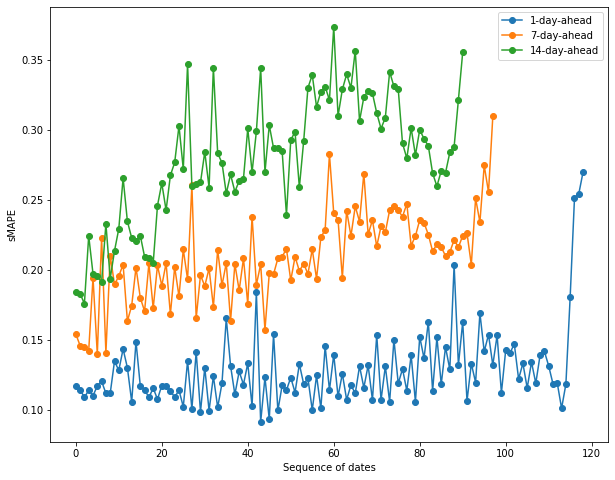

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(df_1.iloc[:, 3], '-o', label = '1-day-ahead')
plt.plot(df_7.iloc[:, 3], '-o', label = '7-day-ahead')
plt.plot(df_14.iloc[:, 3], '-o', label = '14-day-ahead')
#plt.plot(df_28.iloc[:, 3], '-o', label = '28-day-ahead')

plt.xlabel('Sequence of dates')
plt.ylabel('sMAPE')
plt.legend()

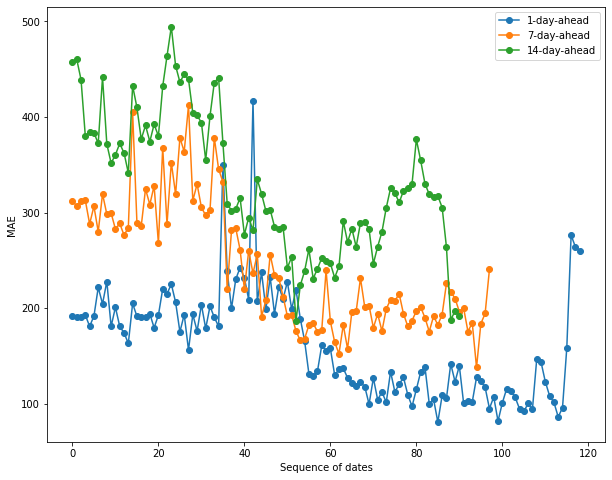

In [85]:
plt.figure(figsize=(10, 8))
plt.plot(df_1.iloc[:, 2], '-o', label = '1-day-ahead')
plt.plot(df_7.iloc[:, 2], '-o', label = '7-day-ahead')
plt.plot(df_14.iloc[:, 2], '-o', label = '14-day-ahead')
#plt.plot(df_28.iloc[:, 2], '-o', label = '28-day-ahead')

plt.xlabel('Sequence of dates')
plt.ylabel('MAE')
plt.legend()

In [25]:
df_covid_cases = pd.read_csv('/content/drive/MyDrive/COVID_DGNN_KG/CDC_COVID19_cases_and_vaccine_time_series/covid_cases_by_county.csv')


In [23]:
df_28.to_csv('/content/drive/MyDrive/COVID_DGNN_KG/CDC_COVID19_cases_and_vaccine_time_series/check.csv')

In [29]:
df_28 = df_covid_cases[df_covid_cases['date'] == '2021-11-26T00:00:00.000']

df_28[df_28['fips_code'] == 6029]

,Unnamed: 0,state_name,county_name,fips_code,date,cases_per_100k_7_day_count,percent_test_results_reported,community_transmission_level
289648,289648,California,Kern County,6029,2021-11-26T00:00:00.000,118.418,NaN,high
